1. Import **Libraries** and **Load Data** **bold text**



In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load fertilizer dataset from a CSV file
data = pd.read_csv('/content/fertilizer_data.csv')

# Display first few rows
print(data.head())

   Temperature   Humidity  Fertilizer_Type
0    27.490802  68.521899                0
1    39.014286  35.048398                1
2    34.639879  39.697723                0
3    31.973170  83.913251                0
4    23.120373  66.385744                1


**2. Data Preprocessing**

Here, I have implemented a model that can give me** Fertilizer type based on 2 input-Temperature and Humidity.**

To implement this i have a loaded a demo dataset containing 3 columns

1.   **Temparature**
2.   **Humidity** and
3. **Fertilizer** type *[(0,1,2) here, 0 representing Nitrozen, 1 representing Phosphorus and 2 representing Potassium]*


**Feature Extraction:** Temperature and Humidity are extracted as X, and Fertilizer Type as y.


**Label Encoding:** The Fertilizer Type is mapped to integer values (e.g., Nitrogen = 0, Phosphorus = 1).

**One-hot Encoding:** The target values are one-hot encoded (e.g., [1, 0, 0] for Nitrogen).

**Normalization:** The feature values (Temperature and Humidity) are normalized to a [0, 1] range using Min-Max scaling.

In [77]:
# Extract Features (Temperature, Humidity) and Target (Fertilizer Type)
X = data[['Temperature', 'Humidity']].values
y = data['Fertilizer_Type'].values

# Mapping the Fertilizer_Type to integers
fertilizer_mapping = {ftype: idx for idx, ftype in enumerate(np.unique(y))}
y = np.array([fertilizer_mapping[label] for label in y])

# One-hot encoding the target (Fertilizer_Type)
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

num_classes = len(fertilizer_mapping)
y_one_hot = one_hot_encode(y, num_classes)

# Normalizing the data (min-max scaling)
X_min, X_max = X.min(axis=0), X.max(axis=0)
X_scaled = (X - X_min) / (X_max - X_min)

# Manual dataset splitting: 80% training, 20% testing
split_index = int(0.8 * X_scaled.shape[0])  # Calculate split index

X_train = X_scaled[:split_index]
y_train = y_one_hot[:split_index]

X_test = X_scaled[split_index:]
y_test = y_one_hot[split_index:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 160
Testing samples: 40


**3. Neural Network Class**

**NeuralNetwork Class:** Implements a multi-layer neural network with 3 hidden layers and an output layer. The key methods are:
sigmoid: Sigmoid activation function with an option for its derivative.

**softmax:** Softmax activation function for the output layer to produce class probabilities.

**feedForward:** Performs a forward pass through the network layers.

**backPropagation:** Updates the weights using the backpropagation algorithm.

In [78]:
class NeuralNetwork:
    def __init__(self):
        inputLayerNeurons = 2  # Features: Temperature, Humidity
        hiddenLayer1Neurons = 6
        hiddenLayer2Neurons = 5
        hiddenLayer3Neurons = 6
        outputLayerNeurons = num_classes  # Output: 3 classes (Fertilizer types)

        # Learning rate
        self.learning_rate = 0.001

        # Initialize weights
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)

    def relu(self, x, der=False):
        if der:
            return np.where(x > 0, 1, 0)
        else:
            return np.maximum(0, x)

    def softmax(self, x):
        exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability fix
        return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

    def feedForward(self, X):
        # Forward pass through 3 hidden layers and output layer
        self.hidden1_output = self.relu(np.dot(X, self.W_H1))
        self.hidden2_output = self.relu(np.dot(self.hidden1_output, self.W_H2))
        self.hidden3_output = self.relu(np.dot(self.hidden2_output, self.W_H3))
        output_input = np.dot(self.hidden3_output, self.W_OH)
        pred = self.softmax(output_input)
        return pred  # Return predictions

    def cross_entropy_loss(self, y_true, y_pred):
        # Cross entropy loss for multi-class classification
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-8), axis=1))

    def backPropagation(self, X, Y, pred):
      # Calculating error and backpropagation
      output_error = Y - pred
      output_delta = self.learning_rate * output_error

      # Using ReLU derivative for hidden layers
      hidden3_error = output_delta.dot(self.W_OH.T)
      hidden3_delta = self.learning_rate * hidden3_error * self.relu(self.hidden3_output, der=True)

      hidden2_error = hidden3_delta.dot(self.W_H3.T)
      hidden2_delta = self.learning_rate * hidden2_error * self.relu(self.hidden2_output, der=True)

      hidden1_error = hidden2_delta.dot(self.W_H2.T)
      hidden1_delta = self.learning_rate * hidden1_error * self.relu(self.hidden1_output, der=True)

      # Updating weights
      self.W_H1 += X.T.dot(hidden1_delta)
      self.W_H2 += self.hidden1_output.T.dot(hidden2_delta)
      self.W_H3 += self.hidden2_output.T.dot(hidden3_delta)
      self.W_OH += self.hidden3_output.T.dot(output_delta)



    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)


**4. Training the Model**

**Training Loop:** The model is trained for 500 iterations.
After each iteration, the loss (mean squared error) is calculated and appended to the err list for tracking.

**Loss Plot:** The error is plotted to visualize how the loss decreases over time.

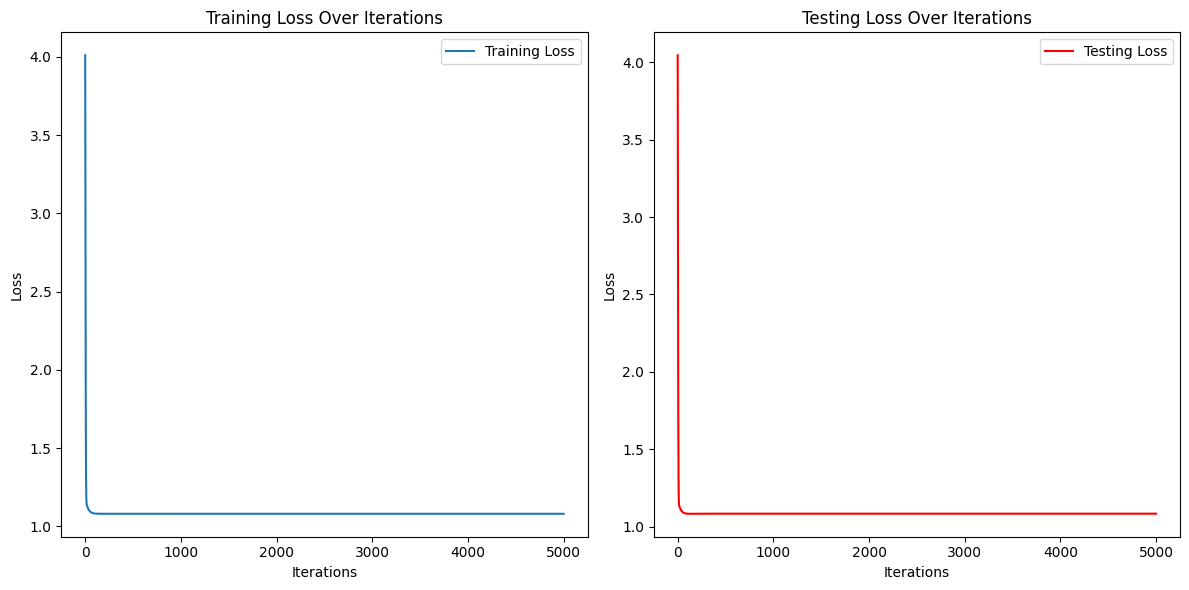

In [81]:
# Initialize the Neural Network
NN = NeuralNetwork()

# Training loop with tracking of loss
train_loss = []
test_loss = []

for i in range(5000):
    # Training the model
    NN.train(X_train, y_train)

    # Calculate and track training loss
    train_predictions = NN.feedForward(X_train)
    train_loss.append(NN.cross_entropy_loss(y_train, train_predictions))  # Use cross-entropy loss for training

    # Calculate and track testing loss
    test_predictions = NN.feedForward(X_test)
    test_loss.append(NN.cross_entropy_loss(y_test, test_predictions))  # Use cross-entropy loss for testing

# Create two separate plots for training and testing losses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training Loss
ax1.plot(train_loss, label="Training Loss")
ax1.set_title("Training Loss Over Iterations")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot Testing Loss
ax2.plot(test_loss, label="Testing Loss", color='red')
ax2.set_title("Testing Loss Over Iterations")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.legend()

# Display both plots
plt.tight_layout()
plt.show()


**TESTING**

In [82]:
# Testing the model
test_predictions = NN.feedForward(X_test)
test_loss_final = NN.cross_entropy_loss(y_test, test_predictions)
test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(y_test, axis=1))

print(f"Final Test Loss: {test_loss_final:.4f}")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

# Display predictions for testing samples
predicted_classes = np.argmax(test_predictions, axis=1)
fertilizer_types = list(fertilizer_mapping.keys())

for i, prediction in enumerate(predicted_classes):
    print(f"Sample {split_index + i + 1}: Predicted Fertilizer Type: {fertilizer_types[prediction]}")


Final Test Loss: 1.0834
Final Test Accuracy: 42.50%
Sample 161: Predicted Fertilizer Type: 0
Sample 162: Predicted Fertilizer Type: 0
Sample 163: Predicted Fertilizer Type: 0
Sample 164: Predicted Fertilizer Type: 0
Sample 165: Predicted Fertilizer Type: 0
Sample 166: Predicted Fertilizer Type: 0
Sample 167: Predicted Fertilizer Type: 0
Sample 168: Predicted Fertilizer Type: 0
Sample 169: Predicted Fertilizer Type: 0
Sample 170: Predicted Fertilizer Type: 0
Sample 171: Predicted Fertilizer Type: 0
Sample 172: Predicted Fertilizer Type: 0
Sample 173: Predicted Fertilizer Type: 0
Sample 174: Predicted Fertilizer Type: 0
Sample 175: Predicted Fertilizer Type: 0
Sample 176: Predicted Fertilizer Type: 0
Sample 177: Predicted Fertilizer Type: 0
Sample 178: Predicted Fertilizer Type: 0
Sample 179: Predicted Fertilizer Type: 0
Sample 180: Predicted Fertilizer Type: 0
Sample 181: Predicted Fertilizer Type: 0
Sample 182: Predicted Fertilizer Type: 0
Sample 183: Predicted Fertilizer Type: 0
Sampl